# Image recognition of Anderson states

## Preliminaries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Checking for GPU

In [ ]:
#import tensorflow as tf
#from tensorflow.python.client import device_lib

#print(tf.test.gpu_device_name())
#print(device_lib.list_local_devices())

#!cat /proc/meminfo

Checking for TPU

In [ ]:
#import os
#assert os.environ['COLAB_TPU_ADDR']
#Path = 'grpc://'+os.environ['COLAB_TPU_ADDR']
#print('TPU Address:', Path)

In [ ]:
import torch
import torch.nn
torch.__version__
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
#!pip install torch=='1.7.0'
#!pip install torchvision=='0.8.1'
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.8.1+cu101
1.7.0+cu101


In [ ]:
import random
import math

In [ ]:
#!pip install fastai==1.0.61
import fastai
from fastai.collab import *
#!pip install --upgrade fastai
#!pip uninstall fastai -y
print(fastai.__version__)
from fastai.vision import *


1.0.61


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Functions and definition of parameters


In [ ]:
def get_files(folder):
  dir = '/content/drive/MyDrive/csvdata/'+folder+'/'
  N = 1    #Desired number of input systems per class
  files = !ls -l {dir}
  print(files)
  files.reverse()
  files.pop()
  for i in range(len(files)):
    files[i] = files[i].rsplit(' ',1)[1]
    print(files[i])
  return dir,files

In [ ]:
d_type_opt = ('training', 'validation')

bs = 25
epoch_chunk = 3
t_f_default = 0.65
v_f_default = 0.25
training_fraction   = t_f_default
validation_fraction = v_f_default

In [ ]:
def to_list(list):
  py_list = []
  for i in list:
    py_list.append(float(i))
  return py_list

##Object definitions

**Definition of our custom Dataset and label_list class for confusion matrix**

In [ ]:
class label_list():
  def __init__(self, data, label_names):
    self.classes = label_names
    self.items = data
  def get(self,i):
    return self.items[i]
  def len(self):
    return len(self.classes)
        

In [ ]:
class ThreeDDataset(Dataset):
    def __init__(self, x, y):
        self.x = []
        self.y = []
        class_ind = 0
        for dis_class in x:
          for item in dis_class:
            self.x.append(item)
            self.y.append(class_ind)
          class_ind+=1
        self.y = label_list(self.y, y)
        print("data: ", len(self.x))
        print("labels: ", self.y.len(), " ", self.y.items)
        self.c = len(self.y.classes)

        t = True
        for dis_class in self.x:
          t = t and len(dis_class)==0
        self.is_empty=t
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y.get(i)

**Definition of our custom Neural Network Model (not yet in use) **

In [ ]:
class NNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv3d(1,30,kernel_size=5,stride=2),
            nn.BatchNorm3d(30),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv3d(1, 30, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm3d(30),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


## Reading in the image data

In [ ]:
"""

#@title Default title text
import os

data   = []
labels = []

datasrc = '/home/epp/phupqr/PX319MLPhases/MachineLearning-Anderson/raw_system_data_refs' #Source of the locations of the data

disorder_systems      = []
disorder_class_labels = []

for disorder_class_folder in os.scandir(datasrc):                #Go through each of the disorder folders...
    print(disorder_class_folder.path)
    disorder_class = disorder_class_folder.path.rsplit('_',1)[1]
    print(disorder_class)
    disorder_systems.append([])
    disorder_class_labels.append(disorder_class)
    
    for file in os.scandir(disorder_class_folder.path):          #...find the file in each folder...
        #print(file)                                             #...
        the_file = open(file.path, 'r')                          #...open the file to read the locations of the data...
        
        number_of_data = 0
        for line in the_file:                                    #...for each... 
            
            if (number_of_data < 1):                           #...gather a certain amount of data...
                print(" ")
                number_of_data += 1

                #print(line)
                line = line.rsplit('\n',1)[0]
                raw_data = open(line,'r')
                system = make_3D_structure(raw_data, 20)
                #print(system)
                disorder_systems[-1].append(system)
                print("added system to " + disorder_class_labels[-1])
     
"""

'\n\n#@title Default title text\nimport os\n\ndata   = []\nlabels = []\n\ndatasrc = \'/home/epp/phupqr/PX319MLPhases/MachineLearning-Anderson/raw_system_data_refs\' #Source of the locations of the data\n\ndisorder_systems      = []\ndisorder_class_labels = []\n\nfor disorder_class_folder in os.scandir(datasrc):                #Go through each of the disorder folders...\n    print(disorder_class_folder.path)\n    disorder_class = disorder_class_folder.path.rsplit(\'_\',1)[1]\n    print(disorder_class)\n    disorder_systems.append([])\n    disorder_class_labels.append(disorder_class)\n    \n    for file in os.scandir(disorder_class_folder.path):          #...find the file in each folder...\n        #print(file)                                             #...\n        the_file = open(file.path, \'r\')                          #...open the file to read the locations of the data...\n        \n        number_of_data = 0\n        for line in the_file:                                    #...f

In [ ]:
def make_3D_structure(file, system_size):
    col = 0
    row = 0
    lay = 0
    
    real_3d_with_channel_system = []
    system = []
    for i in range(system_size):
        system.append([])
        for j in range(system_size):
            system[-1].append([])
            for j in range(system_size):
                system[-1][-1].append([])
    #print(len(system))
    #print(len(system[0]))
    #print(len(system[0][0]))
    
    for line in file:
        if col == system_size:
            col = 0
            row += 1
        if row == system_size:
            row = 0
            lay += 1
        system[col][row][lay] = float(line)
        #print(float(line))
        col += 1
    real_3d_with_channel_system.append(system)
    return system
        

##Primary code that loads data and sends it to correct object

In [ ]:
global loaded_training
global loaded_validation
global loaded_testing
global loaded_labels
loaded_training   = {}
loaded_validation = {}
loaded_testing    = {}
loaded_labels     = {}

In [ ]:
import pandas as pd
import io

def prepare_datasets(folder,d_type, batch_size=1, binning=True,bin_size=1, skip_amount=0):
  folder = folder + d_type
  loaded = False
  class_skipping = (skip_amount>0)

  if str(folder) in loaded_training.keys():
    print("Found pre-loaded data " + folder)
    tensors_training   = loaded_training[str(folder)]
    tensors_validation = loaded_validation[str(folder)]
    tensors_testing    = loaded_testing[str(folder)]
    labels             = loaded_labels[str(folder)]
    loaded = True

  if not loaded:
    if d_type=='validation':
      training_fraction  =0.1
      validation_fraction=0.99
    elif d_type=='training':
      training_fraction  =t_f_default
      validation_fraction=v_f_default

    dir = '/content/drive/MyDrive/csvdata/'+folder+'/'
    files = !ls -l {dir}
    files.reverse()
    files.pop()
    for i in range(len(files)):
      files[i] = files[i].rsplit(' ',1)[1]


    tensors_training   = []  #Each list in this list is a seperate label list
    tensors_validation = []  #
    tensors_testing    = []  #
    global n_labels
    n_labels = len(files)    #Defined by the number of data csv files
    print("Number of classes: ", n_labels)

    labels = []
    class_val = 0
    for class_file in files:
      """
      Add new class to the tensors list, read the systems one by one out 
      of the data file then add that data to the correct class list in tensors
      and add the name of the disorder class to the labels list   
      """
      tensors_training.append([])
      tensors_validation.append([])
      tensors_testing.append([])
      print(class_file)
      disorder_class = class_file.rsplit('-',1)[0]
      disorder_class = disorder_class.rsplit('W',1)[1]
      labels.append(disorder_class)

      with open(dir+class_file, 'r') as f:
        df = pd.read_csv(f)

      for i in range(len(df.transpose())-1):         
        """
        Go through each system and add them to the data
        """           
        ThreeD_array = make_3D_structure(to_list(df[str(i)]),20)
        system = torch.tensor(ThreeD_array)

        ran_numb = random.random()
        if ran_numb >= 1 - training_fraction:
          tensors_training[-1].append(system)
        
        elif ran_numb < validation_fraction:
          tensors_validation[-1].append(system)
        
        else:
          tensors_testing[-1].append(system)
      class_val+=1
    print(labels)

    if str(folder) not in loaded_training.keys():   #Saving the models in a global dictionary for faster loading later
      print("No pre-existing data " + folder + ". Saving in dictionary")
      loaded_training[str(folder)]   = tensors_training
      loaded_validation[str(folder)] = tensors_validation
      loaded_testing[str(folder)]    = tensors_testing
      loaded_labels[str(folder)]     = labels


    
  if class_skipping:    #Skipping every 'skip_amount' classes
    new_labels = []
    for i in range(len(labels)):
      if i*(skip_amount+1) > len(labels)-1:
        break
      new_labels.append(labels[i*(skip_amount+1)])
    labels = new_labels
    print(labels)

    new_tensors_training = []
    for i in range(len(tensors_training)):
      if i*(skip_amount+1) > len(tensors_training)-1:
        break
      new_tensors_training.append(tensors_training[i*(skip_amount+1)])
    tensors_training = new_tensors_training

    new_tensors_validation = []
    for i in range(len(tensors_validation)):
      if i*(skip_amount+1) > len(tensors_validation)-1:
        break
      new_tensors_validation.append(tensors_validation[i*(skip_amount+1)])
    tensors_validation = new_tensors_validation

    new_tensors_testing = []
    for i in range(len(tensors_testing)):
      if i*(skip_amount+1) > len(tensors_testing)-1:
        break
      new_tensors_testing.append(tensors_testing[i*(skip_amount+1)])
    tensors_testing = new_tensors_testing

  if binning:        #Bin each of the datasets
    binned_labels = []
    binned_tensors_training = []
    binned_tensors_validation = []
    binned_tensors_testing = []

    binned_labels.append([])   
    binned_tensors_training.append([])
    binned_tensors_validation.append([])
    binned_tensors_testing.append([])

    print(len(labels)) 
    for i in range(len(labels)):       
      for label in labels[i]:
        binned_labels[-1].append(label)
      if (i+1)%bin_size == 0:
        binned_labels.append([])
    if len(labels)%bin_size != 0:
      del binned_labels[-1]
    print("total bins (la): ", len(binned_labels))
    labels = binned_labels

    print(len(tensors_training)) 
    for i in range(len(tensors_training)):       
      for tensor in tensors_training[i]:
        binned_tensors_training[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_training.append([])
    if len(tensors_training)%bin_size != 0:
      del binned_tensors_training[-1]
    print("total bins (tr): ", len(binned_tensors_training))
    tensors_training = binned_tensors_training

    print(len(tensors_validation))
    for i in range(len(tensors_validation)):
      for tensor in tensors_validation[i]:
        binned_tensors_validation[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_validation.append([])
    if len(tensors_validation)%bin_size != 0:
      del binned_tensors_validation[-1]
    print("total bins (va): ", len(binned_tensors_validation))
    tensors_validation = binned_tensors_validation

    print(len(tensors_testing))
    for i in range(len(tensors_testing)):
      for tensor in tensors_testing[i]:
        binned_tensors_testing[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_testing.append([])
    if len(tensors_testing)%bin_size != 0:
      del binned_tensors_testing[-1]
    print("total bins (te): ", len(binned_tensors_testing))
    tensors_testing = binned_tensors_testing


  loader_training = ThreeDDataset(tensors_training, labels)
  loader_validation = ThreeDDataset(tensors_validation, labels)
  loader_testing = ThreeDDataset(tensors_testing, labels)
  databunch = DataBunch.create(loader_training, loader_validation, loader_testing, bs=bs, num_workers=0)

  return databunch

##Function that creates a learner from a dataset and choice of training or validation mode. Also contains the training function

In [ ]:
def create_learner(folder,d_type, show_model=False, batch_size=1, binning=False,bin_size=1, skip_amount=0, opt=optim.SGD):
  databunch = prepare_datasets(folder, d_type, binning=binning, batch_size=batch_size, bin_size=bin_size, skip_amount=skip_amount)
  global learn 
  learn = cnn_learner(databunch, models.resnet18, metrics=[error_rate,accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=opt, pretrained=False)
  global c_model
  c_model = 'resnet18-'      #Model
  metric = 'metric=error_rate-'     #Metric
  loss = 'loss=CrossEntropyLoss-' #Loss 
  optimizer = 'opt=SGD-'
  twod_or_threed = 'CONV2D-'
  c_model = twod_or_threed+c_model+metric+loss+optimizer


    #Print the layer structure
  for i in range(len(learn.model)):
    #print(i, "    ", learn.model[i])
    for j in range(len(learn.model[i])):
      #print(j, "    ", learn.model[i][j])
      pass

  learn.model[0][0] = nn.Conv2d(20, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)

  if show_model:
    print(learn.model)

  if d_type=='training':
    learn.lr_find(start_lr=1e-4, end_lr=1, num_it=100, stop_div=False)
    learn.recorder.plot()
    learn.recorder.plot_lr()

  c_model_t = c_model +'bs='+str(learn.recorder.train_dl.batch_size)+'-ntrain='+str(learn.recorder.train_dl.dl.dataset.__len__())
  !mkdir /content/drive/MyDrive/ModelStages/{c_model_t}
  learn.save('/content/drive/MyDrive/ModelStages/'
                              +c_model
                              +'bs='+str(learn.recorder.train_dl.batch_size)
                              +'-ntrain='+str(learn.recorder.train_dl.dl.dataset.__len__())
                              +'/epochs-0')

##Training Functions


In [ ]:
def train_max_epochs(epoch_goal, lr, mom):
  n_epochs_total = 0
  #learn.unfreeze()
  validation_losses = []
  training_losses = []
  n_batches = len(learn.recorder.train_dl)
  while n_epochs_total < epoch_goal:
    n_epochs_total = load_latest_training(learn, c_model)
    print("Best training so far: ", n_epochs_total)

    learn.fit_one_cycle(epoch_chunk,max_lr=lr,moms=mom)
    n_epochs_total += epoch_chunk

    print('/content/drive/MyDrive/ModelStages/'+c_model+'/epochs-'+str(n_epochs_total))
    learn.save('/content/drive/MyDrive/ModelStages/'
    +c_model
    +'bs='+str(learn.recorder.train_dl.batch_size)
    +'-ntrain='+str(learn.recorder.train_dl.dl.dataset.__len__())
    +'/epochs-'+str(n_epochs_total)
    +'-max_lr='+str(lr)
    +'-mom='+str(mom))
    
    for c_val_loss in learn.recorder.val_losses:
      validation_losses.append(c_val_loss)
    for i in range(1,epoch_chunk):
      training_losses.append(learn.recorder.losses[i*n_batches-1].item())
    print(learn.recorder.losses)
    print(len(learn.recorder.losses))
    print("losses: ", training_losses)
    print("validation_losses: ", validation_losses)
  learn.recorder.plot_metrics()
  learn.recorder.plot_losses()
  return training_losses, validation_losses

In [ ]:
def load_latest_training(learn, c_model):
  dir = '/content/drive/MyDrive/ModelStages/'+c_model+'bs='+str(learn.recorder.train_dl.batch_size)+'-ntrain='+str(learn.recorder.train_dl.dl.dataset.__len__())+'/'
  training_files = !ls -l {dir}
  training_files.reverse()
  training_files.pop()

  max_epoch_value = 0
  max_epoch_ind = -1
  if len(training_values)!=1:
    for i in range(len(training_files)):
      training_files[i] = training_files[i].rsplit(' ',1)[1]
      if int(training_files[i].rsplit('-',-1)[1].rsplit('-',-1)[0]) > max_epoch_value:
        max_epoch_value = int(training_files[i].rsplit('-',-1)[1].rsplit('-',-1)[0])
        max_epoch_ind = i
    learn.load(training_files[max_epoch_ind])
  else:
    learn.load()
  #learn.load(dir+'epochs-'+str(max_epoch_value))
  
  return max_epoch_value

#Pre-load all available data

#Main Loop

Found pre-loaded data raw_data_transfering_100_training
17
total bins (la):  8
17
total bins (tr):  8
17
total bins (va):  8
17
total bins (te):  8
data:  1029
labels:  8   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=SGD-bs=30-ntrain=1029’: File exists


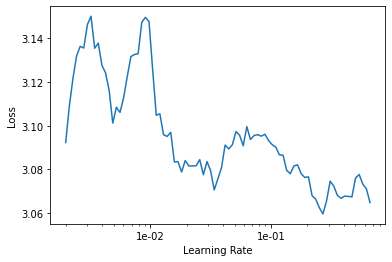

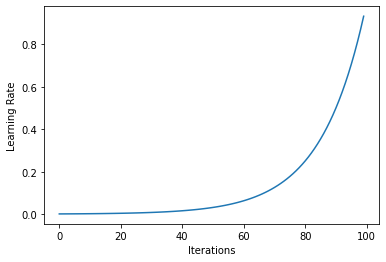

In [ ]:
folder = 'raw_data_transfering_100_'
d_type = d_type_opt[0]
create_learner(folder,d_type, batch_size=20, binning=True,bin_size=2, skip_amount=0)

In [ ]:
train_max_epochs(6,1,0.9)

Best training so far:  0


epoch,train_loss,valid_loss,error_rate,accuracy,time


KeyboardInterrupt: ignored

# Interpretation

In [ ]:
def show_confs(c_model):
  dir = '/content/drive/MyDrive/ModelStages/'+c_model
  epochs = !ls -l {dir}
  epochs.reverse()
  epochs.pop()

  max_epoch_value = 0
  for i in range(len(epochs)):
    epochs[i] = epochs[i].rsplit(' ',1)[1]
    epochs[i] = epochs[i].rsplit('.',1)[0]
  print(epochs)

  for epoch in epochs:
    learn.load('/content/drive/MyDrive/ModelStages/'+c_model+'/'+epoch);
    preds,y,losses = learn.get_preds(with_loss=True)
    interp = ClassificationInterpretation(learn,preds,y,losses)
    interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
#show_confs(c_model)

#learn.load('/content/drive/MyDrive/ModelStages/'+c_model+'/epochs-10');
learn.load('/content/drive/MyDrive/ModelStages/'+'CONV2D-resnet18_error_rate_loss=default'+'/epochs-210');
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_confusion_matrix(figsize=(7,7))

#GridSearch testing area

##Online grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from torch import nn
import numpy as np
from sklearn.datasets import make_classification
!pip install --user skorch
from skorch import NeuralNetClassifier

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=nn.ReLU()):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)


net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}


X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)
gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] lr=0.01, max_epochs=10, module__num_units=10 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... lr=0.01, max_epochs=10, module__num_units=10, total=   0.3s
[CV] lr=0.01, max_epochs=10, module__num_units=10 ....................
[CV] ..... lr=0.01, max_epochs=10, module__num_units=10, total=   0.2s
[CV] lr=0.01, max_epochs=10, module__num_units=10 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ..... lr=0.01, max_epochs=10, module__num_units=10, total=   0.2s
[CV] lr=0.01, max_epochs=10, module__num_units=20 ....................
[CV] ..... lr=0.01, max_epochs=10, module__num_units=20, total=   0.2s
[CV] lr=0.01, max_epochs=10, module__num_units=20 ....................
[CV] ..... lr=0.01, max_epochs=10, module__num_units=20, total=   0.2s
[CV] lr=0.01, max_epochs=10, module__num_units=20 ....................
[CV] ..... lr=0.01, max_epochs=10, module__num_units=20, total=   0.2s
[CV] lr=0.01, max_epochs=20, module__num_units=10 ....................
[CV] ..... lr=0.01, max_epochs=20, module__num_units=10, total=   0.3s
[CV] lr=0.01, max_epochs=20, module__num_units=10 ....................
[CV] ..... lr=0.01, max_epochs=20, module__num_units=10, total=   0.3s
[CV] lr=0.01, max_epochs=20, module__num_units=10 ....................
[CV] ..... lr=0.01, max_epochs=20, module__num_units=10, total=   0.3s
[CV] lr=0.01, max_epochs=20, module__num_units=20 ....................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    5.8s finished


##Our own grid search algorithm

In [ ]:
def train_with_parameters(batch_size, opt, mom, lr):
  folder = 'raw_data_transfering_100_'
  d_type = d_type_opt[0]

  create_learner(folder,d_type, batch_size=batch_size, binning=False,bin_size=2, skip_amount=0, opt=opt)
  training_losses,validation_losses = train_max_epochs(1,lr,mom)
  return training_losses,validation_losses

Found pre-loaded data raw_data_transfering_100_training
data:  1116
labels:  17   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=SGD-bs=25-ntrain=1116’: File exists


ValueError: ignored

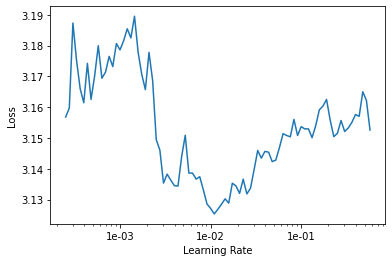

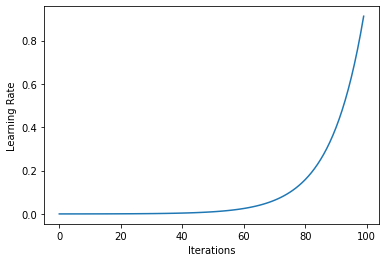

In [ ]:
parameter_lims = {}
parameter_lims['bs']  = [20,30,40]
parameter_lims['opt'] = [optim.SGD]
parameter_lims['mom'] = [0,0.5,0.9]
lr = 0.01

for bs_val in parameter_lims['bs']:
  for opt_val in parameter_lims['opt']:
    for mom_val in parameter_lims['mom']:
      train_losses,valid_losses = train_with_parameters(bs_val, opt_val, mom_val, lr)
      print("train_loss=", train_losses)
      print("valid_loss=", valid_losses)